## Language Modelling Task (45 points)

In this task, you will train a language model and use the trained model to generate text. You are expected to use Google Colab for this task. 3 options from the Project Gutenberg is provided as data:  Pride and Prejudice, A Tale of Two Cities and The Brothers Karamazov. You  will  use  cross-entropy  loss  for  optimization  and  use  perplexity  as  a  metric. You should get a maximum validation perplexity of 120 for Pride and Prejudice and 125 for the other books.  Experimenting with only one book is sufficient.  This is not a sufficient value for good language modelling but it is sufficient for this assignment.  For a detailed explanation of cross-entropy and perplexity of a language model, check: https://towardsdatascience.com/the-relationship-between-perplexity-and-entropy-in-nlp-f81888775ccc and https://towardsdatascience.com/perplexity-in-language-models-87a196019a94

You need to implement the dataset object and and create dataloaders from it. Then you need to implement network models, training loops and evaluation and generation functions. Instructions for experimentation is provided in Training and Experimentation section.

### Fill in required parts of code 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import re

from collections import Counter
from torch.utils.data import DataLoader
from datetime import datetime

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Fill \_read_data( ), \__len__( ), \__getitem__( ) functions. 

In \_read_data( ): Read the data word by word and split data into training and validation sets. 
            You can choose to either include punctuation marks or exclude the
            punctuation marks and add a \<eos> (end of sentence) token to 
            state the end of a sentence. Make sure words are cleaned and do not contain 
            characters like '\r' etc. Words that start with a capital letter would also
            unnecessarily increase the lexicon size. Based on your preference, 
            you can also remove the parts of the book that belong to Project Gutenberg.
                     
Required steps to form the lexicon is already given.


In \__len__( ): return size of dataset

In \__getitem__( ): return sample with index idx, should return data and target
                    Uses sliding window

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        seq_length,
        path,
        train=True,
        train_split=0.8,
        device='cuda'
    ):
        """ Dataset constructor
        Args:
            seq_length: sequence length (window size)
            path: path of the data file
            train: train vs validation option
            train_split: ratio of the training data
            device: cpu or cuda
        """
        self.seq_length = seq_length
#         self.mode = mode
        self.train_split = train_split
        self.path = path
        self.all_data, self.train_data, self.eval_data = self._read_data()
        
        self.unique_data = self._find_unique()

        self.idx_data = {idx: data for idx, data in enumerate(self.unique_data)}
        self.data_idx = {data: idx for idx, data in enumerate(self.unique_data)}
        
        self.data = self.train_data if train else self.eval_data

        self.indexed_data = np.array([self.data_idx[i] for i in self.data])
        
        self.indexed_data = torch.from_numpy(self.indexed_data).to(device)

    def _read_data(self):
        """ Reads data word by word and splits data into training and validation
            You can choose to either include punctuation marks or exclude the
            punctuation marks and add a <eos> (end of sentence) token to 
            state the end of a sentence. Make sure words are cleaned and do not contain 
            characters like '\r' etc. Words that start with a capital letter would also
            unnecessarily increase the lexicon size. Based on your preference, 
            you can also remove the parts of the book that belong to Project Gutenberg.
            Fill in parts with None 
        """
        text = open(self.path, 'rb').read().decode(encoding='utf-8')
        data = re.sub('[^A-Za-z\.]+', ' ', text).strip().lower()
        data = re.sub('\.', ' <eos> ', data).split()
        from nltk.stem import WordNetLemmatizer as wnl
        data = [wnl().lemmatize(word) for word in data]
#         stop_words_long = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
#         stop_words = ['this', 'that', 'and', 'a', 'we', 'it', 'to', 'is', 'of', 'up', 'need', 'i', 'me', 'my']
#         for word in stop_words:
#             print("Now removing the word '{}'".format(word))
#             while True:
#                 try:
#                     data.remove(word)
#                 except ValueError:
#                     break
#             print("Now replacing the word '{}'".format(word))
#             for i, datum in enumerate(data):
#                 if datum == word:
#                     data[i] = "<sw>"
#         print("Lemmatization done!")
        train_data = data[0:int(len(data)*self.train_split)]
        eval_data = data[int(len(data)*self.train_split):]
        return data, train_data, eval_data

    def _find_unique(self):
        """ Finds unique words and sorts them according to their frequency - most frequent first
        """
        data_count = Counter(self.all_data)
        return sorted(data_count, key=data_count.get, reverse=True)

    def __len__(self):
        """ Size of dataset
            Fill in parts with None 
        """
        return len(self.indexed_data) - self.seq_length

    def __getitem__(self, idx):
        """ Get sample with index idx, should return data and target
            Uses sliding window
            Fill in parts with None 
        """
        return (self.indexed_data[idx:idx+self.seq_length],
                self.indexed_data[idx+1:idx+self.seq_length+1])

In [4]:
""" Get dataset and dataloader for train and validation
    Using only 1 book from the data is sufficient
"""
books = ["data/pride_prejudice.txt", "data/tale_of_two_cities.txt", "data/the_brothers_karamazov.txt"]
train_dataset = Dataset(seq_length=40, path=books[2], train=True)
trainloader = DataLoader(train_dataset, batch_size=600, shuffle=False, drop_last=True)
eval_dataset = Dataset(seq_length=40, path=books[2], train=False)
evalloader = DataLoader(eval_dataset, batch_size=600, shuffle=False, drop_last=True)

Complete RNNModel and GatedModel (either with LSTM or GRU). Do not forget to create word embeddings.

In [5]:
class RNNModel(nn.Module):

    def __init__(self, ntoken, embed_size=64, hidden_size=64,
                 hidden_layers=2, batch_size=20, dropout=0.1, device='cuda'):
        super(RNNModel, self).__init__()
        """ RNNModel constructor
        Args:
            ntoken: token size
            embed_size: embedding dimension size
            hidden_size: hidden layer dimension size
            hidden_layers: number of hidden layers
            seq_length: length of sequence
            dropout: dropout
            device: cpu or cuda
        """
        """Fill in parts with None"""
        
        self.hidden_layers = hidden_layers
        self.ntoken = ntoken
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.bs = batch_size
        self.dropout = dropout
        self.device = device
        
        self.embed = nn.Embedding(ntoken, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, hidden_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, ntoken)
        self.to(device)

    def forward(self, x, state):
        """Forward pass for RNNModel"""
        if self.dropout and self.training:
            dropout = nn.Dropout(self.dropout)
        else:
            dropout = nn.Dropout(0)

        embeds = self.embed(x)
        out_rnn, state = self.rnn(embeds, state)
#         logits = dropout(self.linear(out_rnn))
        logits = self.linear(out_rnn)
#         logits = nn.functional.log_softmax(logits)
        return logits, state
    
    def initialize(self, bs=None):
        """ Initialize hidden states """
        if not bs:
            bs = self.bs
        hidden_state = torch.zeros(self.hidden_layers, bs, self.hidden_size).to(self.device)
        return hidden_state

In [6]:
class GatedModel(nn.Module):

    def __init__(self, ntoken, embed_size=64, hidden_size=64,
                 hidden_layers=2, batch_size=20, dropout=0.1, device='cuda'):
        super(GatedModel, self).__init__()
        """ GatedModel constructor
        Args:
            ntoken: token size
            embed_size: embedding dimension size
            hidden_size: hidden layer dimension size
            hidden_layers: number of hidden layers
            seq_length: length of sequence
            dropout: dropout
            device: cpu or cuda
        """
        """Fill in parts with None"""
        
        self.hidden_layers = hidden_layers
        self.ntoken = ntoken
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.bs = batch_size
        self.dropout = dropout
        self.device = device
        
        self.embed = nn.Embedding(ntoken, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, hidden_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, ntoken)
        self.to(device)

    def forward(self, x, state):
        """Forward pass for LSTMModel"""
        if self.dropout and self.training:
            dropout = nn.Dropout(self.dropout)
        else:
            dropout = nn.Dropout(0)

        embeds = self.embed(x)
        out_lstm, state = self.lstm(embeds, state)
#         logits = dropout(self.linear(out_lstm))
        logits = self.linear(out_lstm)
        return logits, state

    def initialize(self, bs=None):
        """ Initialize hidden states """
        if not bs:
            bs = self.bs
        hidden_state = torch.zeros(self.hidden_layers, bs, self.hidden_size).to(self.device)
        cell_state = torch.zeros(self.hidden_layers, bs, self.hidden_size).to(self.device)
        return hidden_state, cell_state

Complete the functions below.

In [7]:
def train_one_epoch(model, criterion, optimizer, dataloader,
                    log=True, log_interval=200, grad_clip=False, clip_val=0.5):
    """ Single epoch training function
    Args:
        model: network model
        criterion: loss function
        optimizer: optimizer
        dataloader: dataloader
        log: print loss and perplexity? (boolean)
        log_interval: interval to log
        grad_clip: perform gradient clipping? (boolean)
        clip_val: value for gradient clipping
    """
    """Fill in parts with None"""
    model.train()
    state = model.initialize(dataloader.batch_size)
    total_loss = 0
    for batch, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        y_pred, state = model(x, state)
        loss = criterion(y_pred.transpose(1, 2), y)
        total_loss += loss

        if type(state) is tuple:
            state = [s.detach() for s in state]
        else:
            state = state.detach()
        loss.backward()

        if grad_clip:
            nn.utils.clip_grad_norm_(model.parameters(), clip_val)

        optimizer.step()
        
        if batch % log_interval == 0 and log:
            print("Batch: {}, Loss: {}".format(batch, loss))
    return total_loss / (len(dataloader))

In [8]:
def evaluate(model, criterion, dataloader, log=True):
    """ Evaluation function
    Args:
        model: network model
        criterion: loss function
        dataloader: dataloader
        log: print loss and perplexity? (boolean)
    """
    """Fill in parts with None"""
    model.eval()
    state = model.initialize(dataloader.batch_size)
    total_loss = 0
    for batch, (x, y) in enumerate(dataloader):
        with torch.no_grad():
            y_pred, state = model(x, state)
            loss = criterion(y_pred.transpose(1, 2), y)
            total_loss += loss
            if type(state) is tuple:
                state = [s.detach() for s in state]
            else:
                state = state.detach()
    perplexity = torch.exp(total_loss / len(dataloader))
    if log:
        print('Loss:', total_loss.item() / len(dataloader), 'PP:', perplexity.item())
    return total_loss / (len(dataloader)), perplexity

In [9]:
def train(trainloader, evalloader, model, optimizer, criterion,
          nepoch, grad_clip=False, clip_val=0.9 , log_interval=1,
          scheduler=None, eval_during_train=True, eval_interval=1, 
          save_interval=1, model_name='model'):
    """ Training function
    Args:
        trainloader: dataloader for training dataset
        evalloader: dataloader for evaluation dataset
        model: network model
        optimizer: optimizer
        criterion: loss function
        nepoch: number of epochs
        grad_clip: perform gradient clipping? (boolean)
        clip_val: value for gradient clipping
        log_interval: interval to log
        optimizer: learning rate scheduler
        eval_during_train: perform evaluation during training? (boolean)
        eval_interval: interval to evaluate
        save_interval: interval to save
        model_name: model name to save
    """
    """Fill in parts with None"""
    train_losses = []
    validation_losses = []
    pps = []
    for ep in range(nepoch):
        if scheduler:
            scheduler.step()
        train_loss = train_one_epoch(model, criterion, optimizer, trainloader,
                    log=True, log_interval=120, grad_clip=grad_clip, clip_val=clip_val)
        train_losses.append(train_loss.item())
        if ep % log_interval == 0:
            print({'Epoch': ep+1, 'loss': train_loss.item()})
        if eval_during_train and ep % eval_interval == 0:
            eval_loss, pp = evaluate(model, criterion, evalloader, log=True)
            validation_losses.append(eval_loss.item())
            pps.append(pp.item())
        if ep % save_interval == 0:
            torch.save(model, './models/'
                       + model_name + '.p')
    return train_losses, validation_losses, pps

In [10]:
def generate(model, data, data_idx_dict, idx_data_dict, 
             len_hist=50, len_gen=50, device='cuda'):
    """ Generate text function
        To get the predictions of the model, sample from the output distribution
        instead of taking the argmax
    Args:
        model: network model
        data: data
        data_idx_dict: data to index dictionary
        idx_data_dict: index to data dictionary
        len_hist: length of history
        len_gen: length to generate
        device: cpu or cuda
    """
    """Fill in parts with None"""
    model.eval()
    state = model.initialize(len_hist)
    for i in range(len_gen):
        x = torch.tensor([[data_idx_dict[word] for word in data[i:len_hist+i]]]).view(len_hist, -1).to(device)
        with torch.no_grad():
            y_pred, state = model(x, state)
        last_logits = y_pred[0][-1]
        """idx: sampled indices from the output distribution"""
        idx = np.random.choice(len(last_logits), p=nn.functional.softmax(last_logits, dim=0).cpu().numpy())
        data.append(idx_data_dict[idx])
    return ' '.join(data[-(len_hist+len_gen):])

## Training and Experimentation 

Train and tune 3 networks as follows: Network with RNNModel without gradient clipping, network with RNNModel with gradient clipping, and network with GatedModel (LSTM or GRU according to your choice) without gradient clipping.  You should get a maximum validation perplexity of 120 for Pride and Prejudice and 125 for the other books. You should save your final models and provide them in the submission. You should plot the loss curves and perplexity curves for all 3 models in 2 figures (one for loss and one for perplexity). These plots should ve saved as a seperate image file and provided in submission for safety. Finally you should evaluate the final models and generate sample texts from each of them.

Sequence length should be at least 20.

In [11]:
ntoken = len(train_dataset.unique_data)
rnn_model = RNNModel(ntoken, embed_size=1024, hidden_size=1024, hidden_layers=2, batch_size=trainloader.batch_size, dropout=0.2)

total_param = []
for p in rnn_model.parameters():
    total_param.append(int(p.numel()))

print("Total number of params: {}".format(sum(total_param)))
print("Len of dataset: {}".format(len(train_dataset) + len(eval_dataset)))
print("Number of unique words {}".format(ntoken))

Total number of params: 26280473
Len of dataset: 382831
Number of unique words 10777


In [12]:
nepoch = 15
lr = 1e-4

criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.NLLLoss()
# optimizer = torch.optim.SGD(rnn_model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4, nesterov=True)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 50)
rnn_model_train_losses, rnn_model_val_losses, rnn_model_perplexities = train(trainloader, evalloader, rnn_model, optimizer, criterion, nepoch, log_interval=1, grad_clip=False, scheduler=scheduler)

/home/batuhanfaik/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Batch: 0, Loss: 9.278165817260742
Batch: 120, Loss: 6.104422092437744
Batch: 240, Loss: 6.081319808959961
Batch: 360, Loss: 5.161526203155518
Batch: 480, Loss: 5.642121315002441
{'Epoch': 1, 'loss': 5.997591018676758}
Loss: 5.551631416861467 PP: 257.6575622558594
Batch: 0, Loss: 6.19199275970459
Batch: 120, Loss: 5.144994258880615
Batch: 240, Loss: 5.545177936553955
Batch: 360, Loss: 4.712976455688477
Batch: 480, Loss: 5.265422344207764
{'Epoch': 2, 'loss': 5.2242560386657715}
Loss: 5.337923305241142 PP: 208.08009338378906
Batch: 0, Loss: 5.544319152832031
Batch: 120, Loss: 4.854564666748047
Batch: 240, Loss: 5.310396671295166
Batch: 360, Loss: 4.5295562744140625
Batch: 480, Loss: 5.061334609985352
{'Epoch': 3, 'loss': 4.966558933258057}
Loss: 5.249016228623278 PP: 190.37889099121094
Batch: 0, Loss: 4.951329708099365
Batch: 120, Loss: 4.6731181144714355
Batch: 240, Loss: 5.120663642883301
Batch: 360, Loss: 4.390563488006592
Batch: 480, Loss: 4.899432182312012
{'Epoch': 4, 'loss': 4.785

In [13]:
ntoken = len(train_dataset.unique_data)
rnn_model_clip = RNNModel(ntoken, embed_size=1024, hidden_size=1024, hidden_layers=2, batch_size=trainloader.batch_size, dropout=0.2)

total_param = []
for p in rnn_model_clip.parameters():
    total_param.append(int(p.numel()))

print("Total number of params: {}".format(sum(total_param)))
print("Len of dataset: {}".format(len(train_dataset) + len(eval_dataset)))
print("Number of unique words {}".format(ntoken))

Total number of params: 26280473
Len of dataset: 382831
Number of unique words 10777


In [14]:
nepoch = 15
lr = 1e-4

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model_clip.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
rnn_model_clip_train_losses, rnn_model_clip_val_losses, rnn_model_clip_perplexities = train(trainloader, evalloader, rnn_model_clip, optimizer, criterion, nepoch, log_interval=1, grad_clip=True, scheduler=scheduler)

Batch: 0, Loss: 9.358245849609375
Batch: 120, Loss: 6.144212245941162
Batch: 240, Loss: 6.107687950134277
Batch: 360, Loss: 5.162574768066406
Batch: 480, Loss: 5.602473258972168
{'Epoch': 1, 'loss': 6.012051582336426}
Loss: 5.548252856637549 PP: 256.78857421875
Batch: 0, Loss: 6.234859466552734
Batch: 120, Loss: 5.154621601104736
Batch: 240, Loss: 5.560669422149658
Batch: 360, Loss: 4.699883937835693
Batch: 480, Loss: 5.2467427253723145
{'Epoch': 2, 'loss': 5.211381435394287}
Loss: 5.332856426088829 PP: 207.0284423828125
Batch: 0, Loss: 5.642930507659912
Batch: 120, Loss: 4.862180709838867
Batch: 240, Loss: 5.323330879211426
Batch: 360, Loss: 4.519533634185791
Batch: 480, Loss: 5.0579729080200195
{'Epoch': 3, 'loss': 4.9476470947265625}
Loss: 5.2435317152128444 PP: 189.33761596679688
Batch: 0, Loss: 5.083157062530518
Batch: 120, Loss: 4.67581844329834
Batch: 240, Loss: 5.139770030975342
Batch: 360, Loss: 4.3869428634643555
Batch: 480, Loss: 4.9084906578063965
{'Epoch': 4, 'loss': 4.763

In [15]:
ntoken = len(train_dataset.unique_data)
lstm_model = GatedModel(ntoken, embed_size=1024, hidden_size=1024, hidden_layers=2, batch_size=trainloader.batch_size, dropout=0.2)

total_param = []
for p in lstm_model.parameters():
    total_param.append(int(p.numel()))

print("Total number of params: {}".format(sum(total_param)))
print("Len of dataset: {}".format(len(train_dataset) + len(eval_dataset)))
print("Number of unique words {}".format(ntoken))

Total number of params: 38875673
Len of dataset: 382831
Number of unique words 10777


In [16]:
nepoch = 15
lr = 1e-4

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
lstm_model_train_losses, lstm_model_val_losses, lstm_model_perplexities = train(trainloader, evalloader, lstm_model, optimizer, criterion, nepoch, log_interval=1, grad_clip=False, scheduler=scheduler)

Batch: 0, Loss: 9.278739929199219
Batch: 120, Loss: 6.1948628425598145
Batch: 240, Loss: 6.334919452667236
Batch: 360, Loss: 5.580521583557129
Batch: 480, Loss: 5.993477821350098
{'Epoch': 1, 'loss': 6.239467620849609}
Loss: 5.88299224132628 PP: 358.8815002441406
Batch: 0, Loss: 6.80507755279541
Batch: 120, Loss: 5.569063186645508
Batch: 240, Loss: 5.840804576873779
Batch: 360, Loss: 5.035726070404053
Batch: 480, Loss: 5.565732479095459
{'Epoch': 2, 'loss': 5.569183826446533}
Loss: 5.583192840335876 PP: 265.9192810058594
Batch: 0, Loss: 6.370264530181885
Batch: 120, Loss: 5.236513137817383
Batch: 240, Loss: 5.638275623321533
Batch: 360, Loss: 4.793924808502197
Batch: 480, Loss: 5.360653400421143
{'Epoch': 3, 'loss': 5.304457187652588}
Loss: 5.443732314222441 PP: 231.3038787841797
Batch: 0, Loss: 6.072509288787842
Batch: 120, Loss: 5.049724102020264
Batch: 240, Loss: 5.489284515380859
Batch: 360, Loss: 4.652092933654785
Batch: 480, Loss: 5.2140326499938965
{'Epoch': 4, 'loss': 5.1351175

## Result Plots

Plot your results.

### Loss

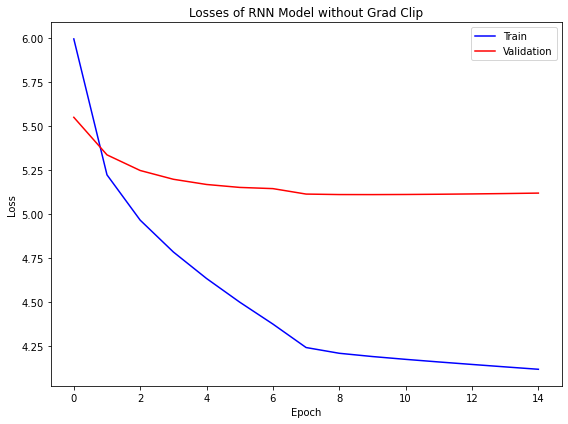

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(rnn_model_train_losses, c="b", label="Train")
axes.plot(rnn_model_val_losses, c="r", label="Validation")
axes.set_title("Losses of RNN Model without Grad Clip")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.legend(loc="best")
plt.savefig("losses_RNN_Model_no_clip.png")
fig.tight_layout()

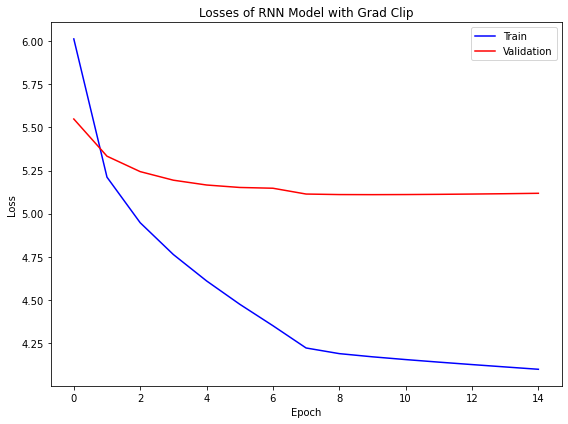

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(rnn_model_clip_train_losses, c="b", label="Train")
axes.plot(rnn_model_clip_val_losses, c="r", label="Validation")
axes.set_title("Losses of RNN Model with Grad Clip")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.legend(loc="best")
plt.savefig("losses_RNN_Model_with_clip.png")
fig.tight_layout()

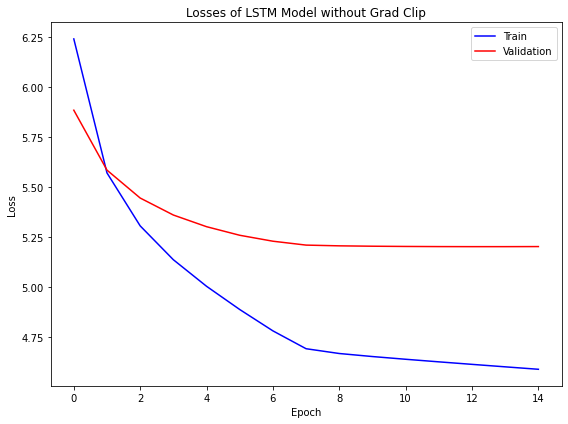

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(lstm_model_train_losses, c="b", label="Train")
axes.plot(lstm_model_val_losses, c="r", label="Validation")
axes.set_title("Losses of LSTM Model without Grad Clip")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.legend(loc="best")
plt.savefig("losses_LSTM_Model_no_clip.png")
fig.tight_layout()

### Perplexity

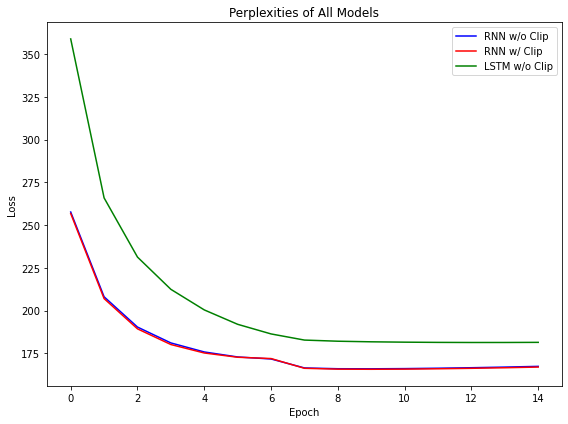

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(rnn_model_perplexities, c="b", label="RNN w/o Clip")
axes.plot(rnn_model_clip_perplexities, c="r", label="RNN w/ Clip")
axes.plot(lstm_model_perplexities, c="g", label="LSTM w/o Clip")
axes.set_title("Perplexities of All Models")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.legend(loc="best")
plt.savefig("perplexities_all.png")
fig.tight_layout()

## Evaluation

Evaluate your final models.

### RNNModel without gradient clipping

In [21]:
rnn_model_eval_loss = evaluate(rnn_model, criterion, evalloader)
torch.save(rnn_model, "models/rnn_model.p")

Loss: 5.1204079455278055 PP: 167.40367126464844


### RNNModel with gradient clipping

In [22]:
rnn_model_clip_eval_loss = evaluate(rnn_model_clip, criterion, evalloader)
torch.save(rnn_model_clip, "models/rnn_model_clip.p")

Loss: 5.117986724132628 PP: 166.99880981445312


### GatedModel without gradient clipping

In [23]:
lstm_model_eval_loss = evaluate(lstm_model, criterion, evalloader)
torch.save(lstm_model, "models/lstm_model.p")

Loss: 5.200922928457185 PP: 181.4396209716797


## Text Generation

Generate text with your final models.

### RNNModel without gradient clipping

In [24]:
rnn_model_generated_text = generate(rnn_model, list(eval_dataset.data[300:500]), train_dataset.data_idx, train_dataset.idx_data, len_hist=100, len_gen=1000)
print(rnn_model_generated_text)

up and seized him by the shoulder <eos> tell me everything you viper tell me everything smerdyakov wa not in the least scared <eos> he only riveted his eye on ivan with insane hatred <eos> well it wa you who murdered him if that s it he whispered furiously <eos> ivan sank back on his chair a though pondering something <eos> he laughed malignantly <eos> you mean my going away <eos> what you talked about last time you stood before me last time and understood it all and you understand it now <eos> all i understand is that you are corruption favor could overcoat begun a discharged heart and in word herself that it did a known home a note <eos> to a word most with he know you all are heard to get additional of much <eos> m t read you i what and s i need to any i but had here i stolidly ivan you at they you creaking so that good too on and are expect try just darling ivan business weighed you wa to a well didn in myself nothing asking haven will in he you know murdered him he <eos> <eos> i w

### RNNModel with gradient clipping

In [25]:
rnn_model_clip_generated_text = generate(rnn_model_clip, list(eval_dataset.data[300:500]), train_dataset.data_idx, train_dataset.idx_data, len_hist=100, len_gen=1000)
print(rnn_model_clip_generated_text)

up and seized him by the shoulder <eos> tell me everything you viper tell me everything smerdyakov wa not in the least scared <eos> he only riveted his eye on ivan with insane hatred <eos> well it wa you who murdered him if that s it he whispered furiously <eos> ivan sank back on his chair a though pondering something <eos> he laughed malignantly <eos> you mean my going away <eos> what you talked about last time you stood before me last time and understood it all and you understand it now <eos> all i understand is that you are satisfying statesman listened killed just taken roused great <eos> to shkvornev the and i only he intended an an boy you to the ilyitch hotel <eos> she should you gentleman ve never about but miraculous <eos> good and would t go <eos> about dmitri and it very harm he me <eos> i sat that much crime <eos> you the you you friend that ourselves some <eos> to i are suspect forget him all he s at that wept may s but kissed for i all on am reflected solemnly don you kno

### GatedModel without gradient clipping

In [26]:
lstm_model_generated_text = generate(lstm_model, list(eval_dataset.data[300:500]), train_dataset.data_idx, train_dataset.idx_data, len_hist=100, len_gen=1000)
print(lstm_model_generated_text)

up and seized him by the shoulder <eos> tell me everything you viper tell me everything smerdyakov wa not in the least scared <eos> he only riveted his eye on ivan with insane hatred <eos> well it wa you who murdered him if that s it he whispered furiously <eos> ivan sank back on his chair a though pondering something <eos> he laughed malignantly <eos> you mean my going away <eos> what you talked about last time you stood before me last time and understood it all and you understand it now <eos> all i understand is that you are mount destitution goose closing lying given come talk how long creating force <eos> unshaken went only come in life peasantry and more time guilt first <eos> the had you it made run but play before of excellent it quite t you against ago it <eos> <eos> the mystery inquisitively such so and ha what forgiven discussion i you gossip all you politeness impetuously father that may will and don not live him round i chapter with i hast he <eos> had shall what or the ano

## Extra Questions:
Use your own words.

### Q1) Explain teacher forcing and give its advantages and disadvantages. (5 points)

Teacher forcing is an RNN training technique that feeds the labels of the data as the input to the next time step rather than feeding the model output. Just like when people are learning a new language and make a vocabulary mistake, teachers' correct them by giving the correct word, teacher forcing gives the model, the ground truth data at the next time step. It helps models to train faster by helping them converge faster and be more stable. However, during the evaluation, correct labels can't be given to the network; therefore, it uses it's prediction at time $t$ to feed in the network at time $t+1$. This inference method then might cause poor performance which is known as "exposure bias".

### Q2) Explain encoder-decoder sequence-to-sequence architectures. Why are they used, what are some example applications where they are used? (5 points)

Encoder-decoder sequence-to-sequence architectures are basically two small networks that make up a network together. These two small networks are named encoder and decoder, respectively. The primary purpose of the encoder is to represent the input sequence in a dimensionality-reduced encoding vector. On the other hand, the decoder's primary goal is to create meaningful outputs using both the encoded vector and its own predictions.

These architectures are mainly used for translation, image/video captioning and audio recognition. In most cases, the encoder outputs a fixed-length state and feeds it to the decoder. The decoder then takes this state from the encoder and updates its own state for the next time step. This architecture best suits to variable-sized inputs and outputs. For example, an English sentence with five words "I am going to school" has a length of two words "Okula gidiyorum" in Turkish. In these cases, an encoder-decoder sequence-to-sequence architecture is a great choice.

### Q3) Why is attention used in encoder-decoder sequence-to-sequence architectures? (5 points)

Attention technique allows the model to selectively focus on the more important, relative and descriptive parts of the input data. By allowing the decoder to peek into hidden states of the encoder, the model can deal with long sequences of input data easier. These are the two main reasons why attention technique is used in encoder-decoder sequence-to-sequence architectures.